## Setup

In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rc("figure", figsize=(10,7))

import poissonlearning as pl

import storage
import plotting

plotting.setup(latex=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
SAVE_PLOTS = True
NUM_PLOTTING_POINTS = 5000

### Convenience functions

In [28]:
def compute_analytic_solution(x, label_locations):
    green_first_label = pl.datasets.line.greens_function(x=x, z=label_locations[0])
    green_second_label = pl.datasets.line.greens_function(x=x, z=label_locations[1])
    solution_analytic = pd.Series(
        0.5 * green_first_label - 0.5 * green_second_label, index=x
    )
    return solution_analytic


def compute_errors(experiments):
    for experiment in experiments:
        solution = experiment["solution"]
        x = solution.index
        analytic = compute_analytic_solution(x, experiment["label_locations"])
        error_L1 = np.abs(solution - analytic).mean()
        experiment["error_L1"] = error_L1

        # Compute error to dirac experiment, if exists
        e_dirac = list(
            filter(
                lambda x: x["seed"] == experiment["seed"]
                and x["n"] == experiment["n"]
                and np.isclose(x["eps"], experiment["eps"])
                and np.allclose(x["label_locations"], experiment["label_locations"])
                and x["kernel"] == experiment["kernel"]
                and x["bump"] == "dirac",
                experiments,
            )
        )
        if e_dirac:
            error_L1_dirac = np.abs(solution - e_dirac[0]["solution"]).mean()
            experiment["error_L1_dirac"] = error_L1_dirac


### Load experiments and compute errors

In [29]:
experiments = storage.load_results(name="line", folder="../results")
compute_errors(experiments)

## Plotting

In [30]:
colors = plotting.get_plot_colors(n=5)

### Convergence of dirac solutions

In [31]:
kernel = "uniform"
selected_experiments = {
    f"n={n}": list(
        filter(
            lambda x: x["kernel"] == kernel
            and x["bump"] == "dirac"
            and x["n"] == n,
            experiments,
        )
    )[0]
    for n in [10000, 20000, 50000, 100000, 300000]
}
solution_analytic = compute_analytic_solution(np.linspace(0, 1, NUM_PLOTTING_POINTS), experiments[0]["label_locations"])

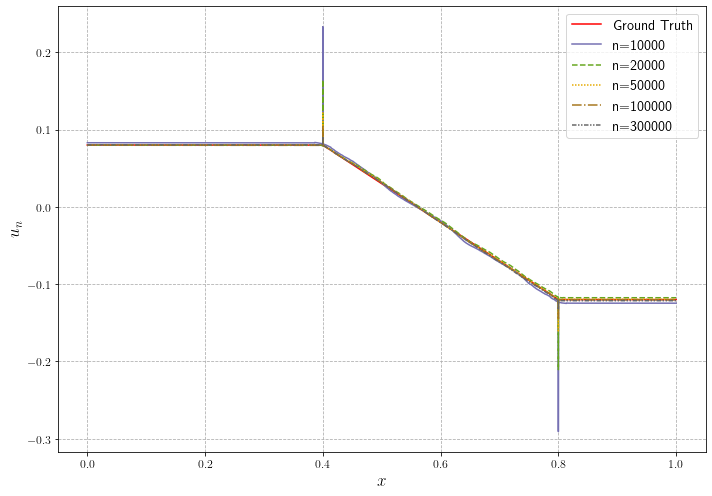

In [32]:
fig, ax = plt.subplots(1, 1)
plotting.results_1D(
    selected_experiments,
    ax=ax,
    truth=solution_analytic,
    num_plotting_points=NUM_PLOTTING_POINTS,
    colors=colors,
)

# ax_dirac.set_title(f"Convergence of Dirac RHS with kernel '{kernel}'")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u_n$")
ax.legend()
ax.grid(linestyle="dashed")
fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../results/line_demo.svg", bbox_inches="tight")

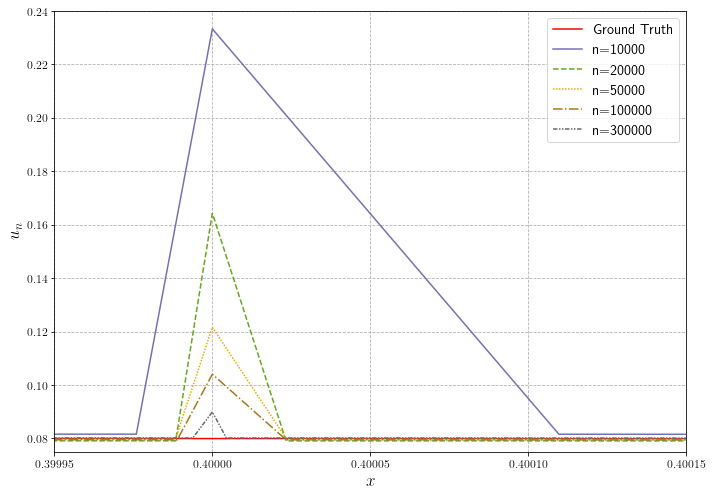

In [33]:
fig, ax = plt.subplots(1, 1)
plotting.results_1D(
    selected_experiments,
    ax=ax,
    truth=solution_analytic,
    num_plotting_points=NUM_PLOTTING_POINTS,
    colors=colors,
)

# ax_dirac.set_title(f"Convergence of Dirac RHS with kernel '{kernel}'")
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u_n$")
ax.legend()
ax.grid(linestyle="dashed")
ax.set_xlim(0.39995, 0.40015)
ax.set_ylim(0.075, 0.24)
ax.set_xticks(np.linspace(0.39995, 0.40015, 5))
fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../results/line_demo_zoom.svg", bbox_inches="tight")

### Convergence of bumps

In [34]:
n = 300000
kernel = "gaussian"
selected_experiments = {
    f"bump width={bump}": list(
        filter(
            lambda x: x["kernel"] == kernel and x["bump"] == bump and x["n"] == n,
            experiments,
        )
    )[0]
    for bump in ["dirac", 0.001, 0.01, 0.1]
}

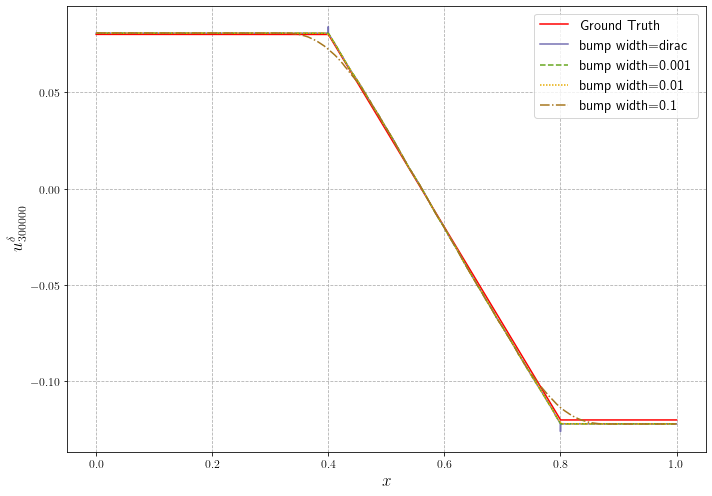

In [35]:
fig, bump = plt.subplots(1, 1)
plotting.results_1D(
    selected_experiments,
    ax=bump,
    truth=solution_analytic,
    num_plotting_points=NUM_PLOTTING_POINTS,
    colors=colors,
)
# bump.set_title(f"Convergence of smoothed RHS with kernel '{kernel}', n={n}")
bump.set_xlabel(r"$x$")
bump.set_ylabel(fr"$u_{ {n} }^\delta$")
bump.legend()
bump.grid(linestyle="dashed")
fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../results/line_delta.svg", bbox_inches="tight")

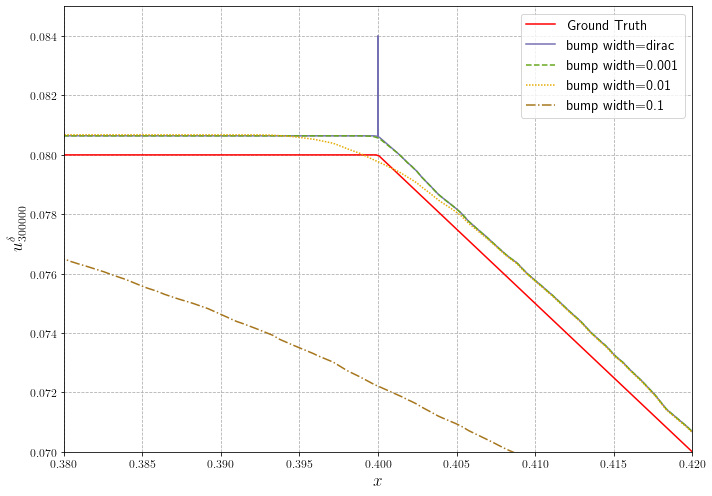

In [36]:
fig, ax = plt.subplots(1, 1)
plotting.results_1D(
    selected_experiments,
    ax=ax,
    truth=solution_analytic,
    num_plotting_points=NUM_PLOTTING_POINTS,
    colors=colors,
)
# ax.set_title(f"Convergence of smoothed RHS with kernel '{kernel}', n={n}")
ax.set_xlabel(r"$x$")
ax.set_ylabel(fr"$u_{ {n} }^\delta$")
ax.legend()
ax.grid(linestyle="dashed")
ax.set_xlim(0.38, 0.42)
ax.set_ylim(0.07, 0.085)
fig.tight_layout()

if SAVE_PLOTS:
    fig.savefig(f"../results/line_delta_zoom.svg", bbox_inches="tight")

### Errors for dirac solutions

In [37]:
selected_experiments = {
    kernel: list(
        filter(
            lambda x: x["kernel"] == kernel and x["bump"] == "dirac", experiments,
        )
    )
    for kernel in ["uniform", "gaussian"]
}
n_error = sorted(list(set([e["n"] for e in list(selected_experiments.values())[0]])))
error = {kernel: {} for kernel in selected_experiments.keys()}
for kernel, experiments_with_kernel in selected_experiments.items():
    for n in n_error:
        ex = list(filter(lambda x: x["n"] == n, experiments_with_kernel))
        error[kernel][n] = {}
        error[kernel][n]["mean"] = np.mean([e["error_L1"] for e in ex])
        error[kernel][n]["max"] = np.max([e["error_L1"] for e in ex])
        error[kernel][n]["min"] = np.min([e["error_L1"] for e in ex])

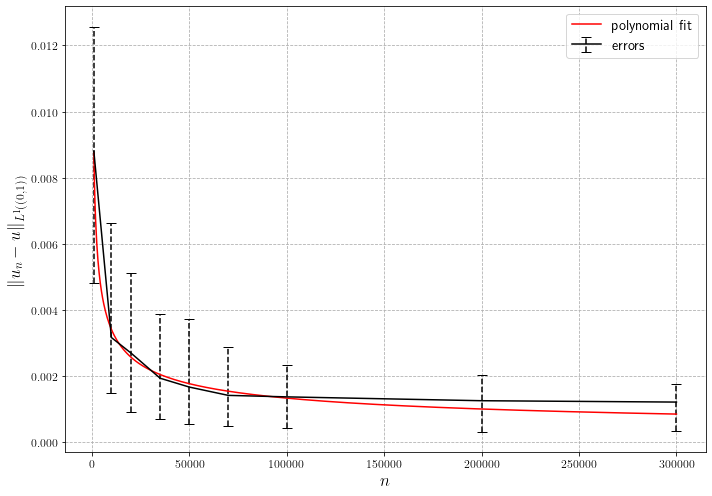

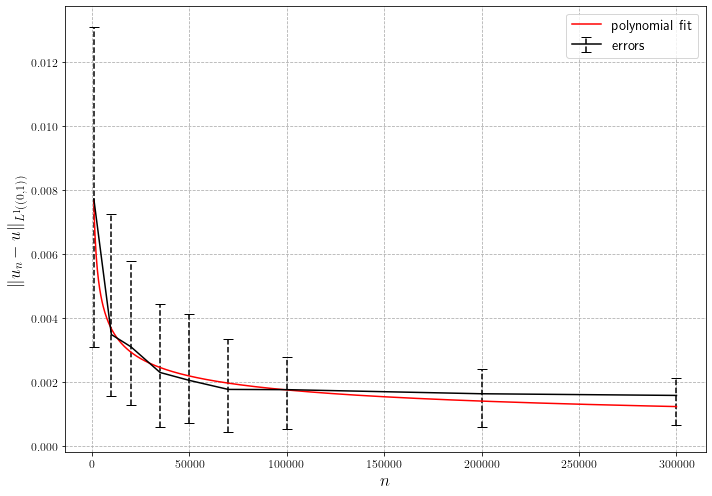

In [38]:
for kernel, e in error.items():
    fig, ax = plt.subplots(1, 1)
    plotting.error_plot({kernel: e}, ax, fit="polynomial")

    # ax.set_xscale("log")
    # ax.set_title("L1 error of solution with dirac RHS")
    ax.legend()
    ax.set_xlabel(r"$n$")
    ax.set_ylabel(r"$\lVert u_n - u \rVert_{L^1 \left((0, 1) \right)}$")

    fig.tight_layout()
    if SAVE_PLOTS:
        fig.savefig(f"../results/line_dirac_n_{kernel}.svg", bbox_inches="tight")

### Errors for bump convergence

In [39]:
n = 300000
selected_experiments = {
    kernel: list(
        filter(lambda x: x["kernel"] == kernel and x["n"] == n, experiments,)
    )
    for kernel in ["gaussian"]
}

bump_error = list(set([e["bump"] for e in list(selected_experiments.values())[0]]))
bump_error = sorted([b for b in bump_error if isinstance(b, float)])
error = {kernel: {} for kernel in selected_experiments.keys()}
for kernel, experiments_with_kernel in selected_experiments.items():
    for bump in bump_error:
        ex = list(filter(lambda x: x["bump"] == bump, experiments_with_kernel))
        bump_inv = 1.0 / bump
        error[kernel][bump_inv] = {}
        error[kernel][bump_inv]["mean"] = np.mean([e["error_L1_dirac"] for e in ex])
        error[kernel][bump_inv]["max"] = np.max([e["error_L1_dirac"] for e in ex])
        error[kernel][bump_inv]["min"] = np.min([e["error_L1_dirac"] for e in ex])

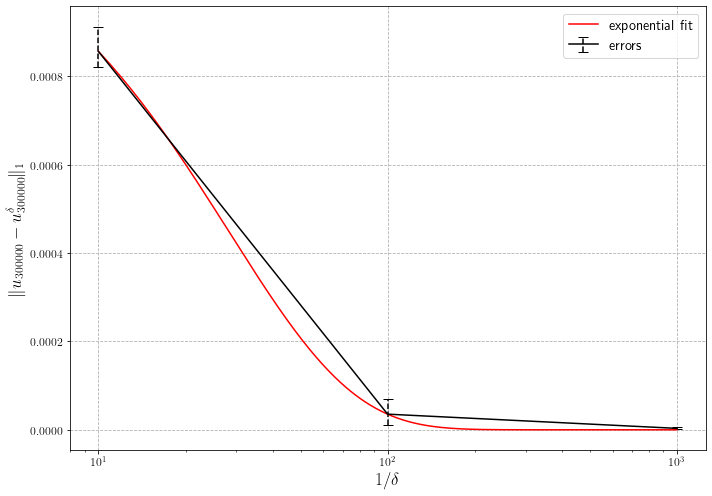

In [40]:
for kernel, e in error.items():
    fig, ax = plt.subplots(1, 1)
    plotting.error_plot({kernel: e}, ax, fit="exponential")

    # ax.set_xscale("log")
    # ax.set_title("L1 error of solution with dirac RHS")
    ax.legend()
    ax.set_xlabel(r"$1/\delta$")
    ax.set_ylabel(fr"$\lVert u_{ {n} } - u_{ {n} }^\delta \rVert_1$")
    ax.set_xscale("log")

    fig.tight_layout()
    if SAVE_PLOTS:
        fig.savefig(f"../results/line_delta_{kernel}.svg", bbox_inches="tight")